In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('data/llm_predictions.parquet')
df = df[df['model'] == 'qwen2.5:0.5b']
comments_df =pd.read_parquet('data/comments.parquet')
df = df.merge(
        comments_df[['id', 'rating', 'comment_length', 'pros_length_proportion', 'comment_length_group', 'pros_length_proportion_group']].rename(columns={'rating':'real_rating'}),
        on='id',
        how='inner'
    )
df['is_inconsistent'] = (
            (df['rating'] - df['real_rating'] > 1) |
            (df['rating'] - df['real_rating'] < -1)
            ).astype(int)

In [2]:
def select_llm_inconsistent_ids(model='qwen2.5:0.5b', llm_predictions_path='data/llm_predictions.parquet'):
    df = pd.read_parquet(llm_predictions_path)
    df = df[df['model'] == model]
    df = df.merge(
        comments_df[['id', 'rating']].rename(columns={'rating':'real_rating'}),
        on='id',
        how='inner'
    )
    df['is_inconsistent'] = (
                (df['rating'] - df['real_rating'] > 1) |
                (df['rating'] - df['real_rating'] < -1)
                )
    df = df[df['is_inconsistent'] == True]
    return set(df['id'])
inconsistent_ids = select_llm_inconsistent_ids()
print(inconsistent_ids)

{'4250053aeac0c16978fefa0b38b1faf9c836f218826299be7d989acab25bb9cc', '5f0888c1d74a6ebbb7ba3ea4e1a94e88391cae13ad10d69f82bd6fad795452df', '9bca365c84fdc0e08603781e596ed50d950e88f5c30257bbc920d328839b728c', 'cea8f5cf84481be885f1ee4ce551773783443088d9a27fc0aca11ff781848826', '92fae389f1a40ba9784545e558f350b828e1d4892c3383c5ae5dc870598575ce', '824e4e97c507cd896cdb0ac94487f904ff09f7b2e6542d46696f76daefa6e913', 'ea07d2c755dc4fa548d3cfea8459584d2257e82db2b720244172239c13455c22', '48fe00b2523265acf29470b1dd810bdb8cbcad014db4ff08fb5bd77d6af89dde', '274104de2bc960822949070ce82885dd5ca4ab057e05b9b2baaf06f4b075e41f', 'ee976a54eff8940ef9457a643adb3d240ed8580c7ba23de84bbfa6dd21bdc14d', '9bb6e400194df2db95732fdae502e22d2a9c31ab6aebc14ee382d51a1540d446', 'f14424ed5e615849a4e0a01c6e18cfee579fd39c59cb4e4cd5e8e3e2049b867b', '4aa80bddf7e4d839e19f143e2ab4b1a1e1bac1d8bc5ab6ec3b0b63ab6edfa9f3', '10e7e987d67d35ed648ae7f6d5cc4fc669b1d12873bacd074695948f63b59436', '5b66dc4fe6e70149d1ba29c91d03671b418de44faf3b62

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            955 non-null    object        
 1   model                         955 non-null    object        
 2   rating                        955 non-null    int64         
 3   prediction_time               955 non-null    float64       
 4   ts_prediction                 955 non-null    datetime64[ns]
 5   extra_info                    955 non-null    object        
 6   processing_time               955 non-null    float64       
 7   real_rating                   955 non-null    int64         
 8   comment_length                955 non-null    int64         
 9   pros_length_proportion        955 non-null    int64         
 10  comment_length_group          955 non-null    int64         
 11  pros_length_proportion_group  95

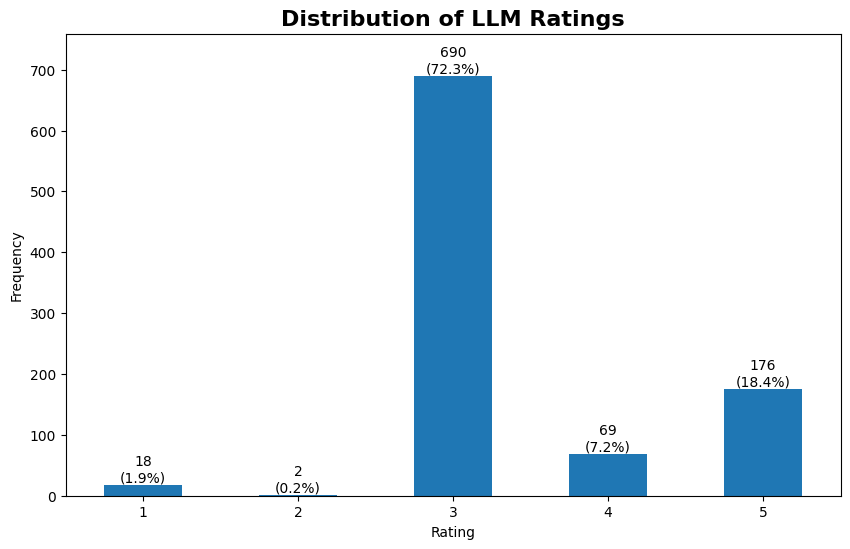

In [4]:
rating_counts = df['rating'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of LLM Ratings', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

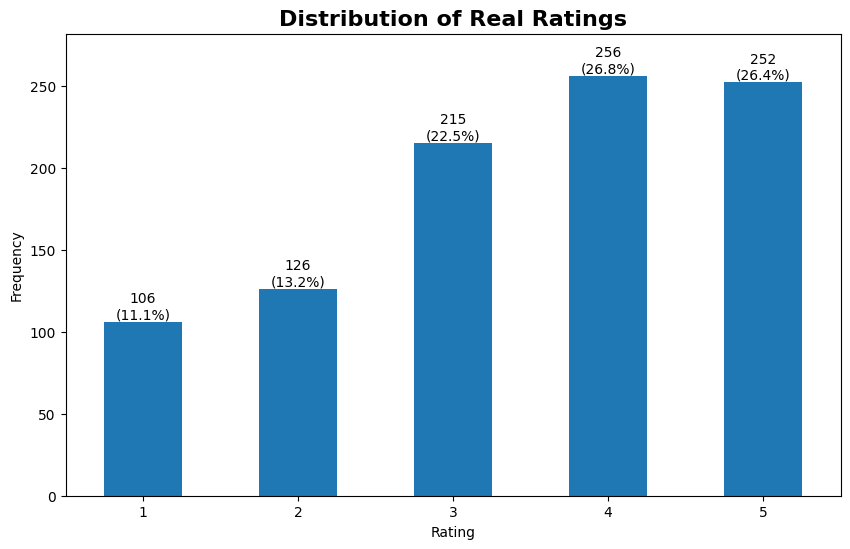

In [5]:
real_rating_counts = df['real_rating'].value_counts().sort_index()
total = real_rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = real_rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Real Ratings', fontsize=16, fontweight='bold')
ax.set_ylim(0, real_rating_counts.max() * 1.1)

for i, count in enumerate(real_rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

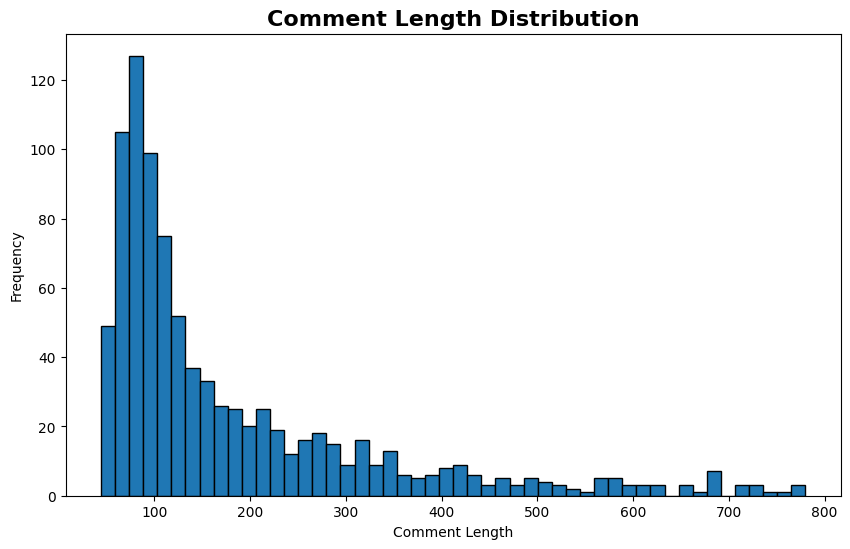

In [6]:
max_length = df['comment_length'].quantile(0.95)
filtered = df[df['comment_length'] <= max_length]

plt.figure(figsize=(10,6))
plt.hist(filtered['comment_length'], bins=50, edgecolor='black')
plt.title('Comment Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

In [7]:
percentiles = df['comment_length'].quantile([0.2, 0.4, 0.6, 0.8]).reset_index()
percentiles.columns = ['Percentile', 'Comment Length']
display(percentiles)


,Percentile,Comment Length
0,0.2,77.0
1,0.4,103.0
2,0.6,160.4
3,0.8,309.2


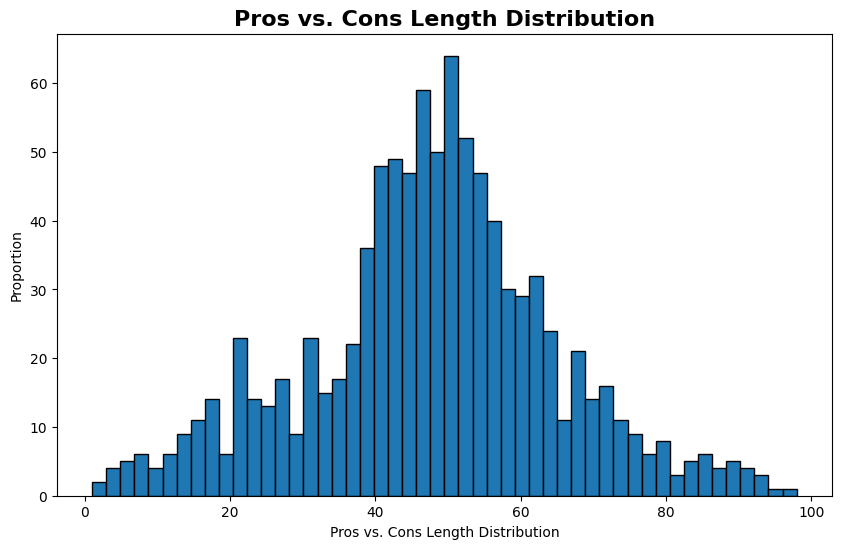

In [8]:
plt.figure(figsize=(10,6))
plt.hist(df['pros_length_proportion'], bins=50, edgecolor='black')
plt.title('Pros vs. Cons Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Pros vs. Cons Length Distribution')
plt.ylabel('Proportion')
plt.show()

In [9]:
percentiles = df['pros_length_proportion'].quantile([0.2, 0.4, 0.6, 0.8]).reset_index()
percentiles.columns = ['Percentile', 'Pros vs. Cons Length Distribution']
display(percentiles)


,Percentile,Pros vs. Cons Length Distribution
0,0.2,35.0
1,0.4,45.0
2,0.6,51.4
3,0.8,61.0


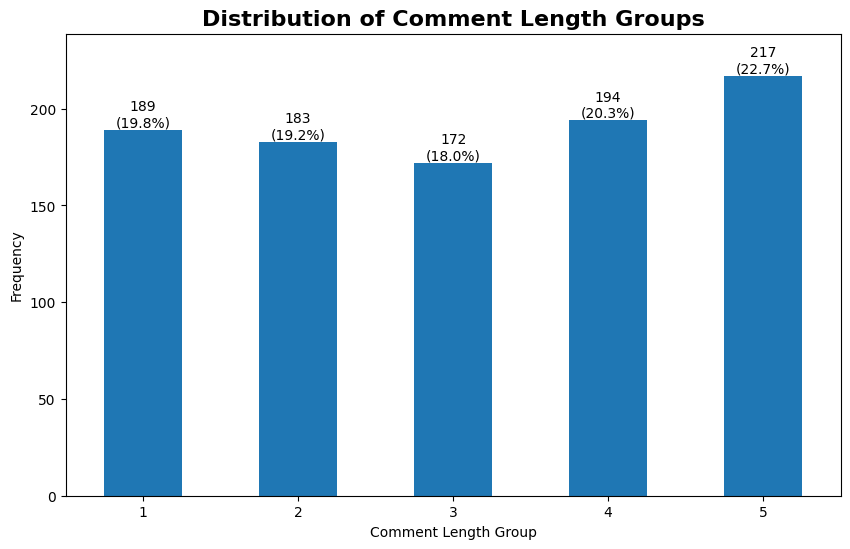

In [10]:
rating_counts = df['comment_length_group'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Comment Length Group')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Length Groups', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

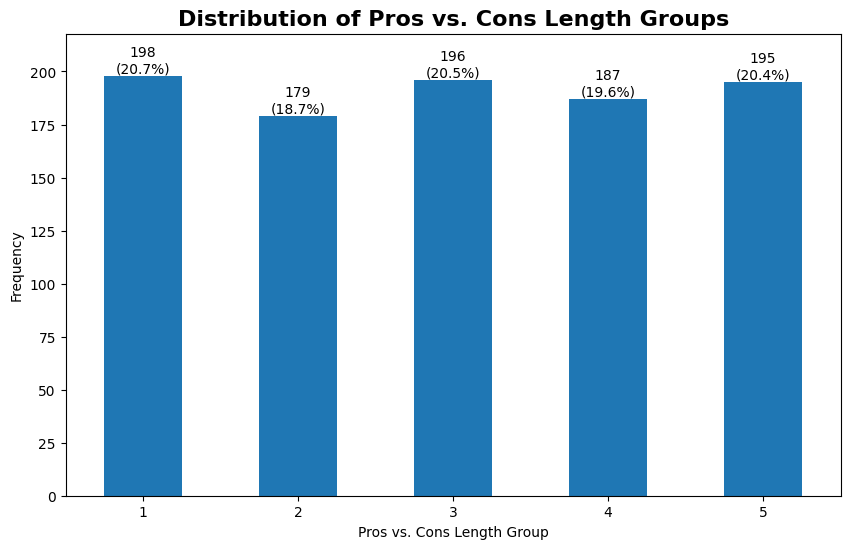

In [11]:
rating_counts = df['pros_length_proportion_group'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Pros vs. Cons Length Group')
plt.ylabel('Frequency')
plt.title('Distribution of Pros vs. Cons Length Groups', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [12]:
cross_tab = pd.crosstab(df['comment_length_group'], df['pros_length_proportion_group'])
print(cross_tab)

pros_length_proportion_group   1   2   3   4   5
comment_length_group                            
1                              5  42  78  45  19
2                             15  35  34  62  37
3                             26  42  39  34  31
4                             62  39  23  26  44
5                             90  21  22  20  64


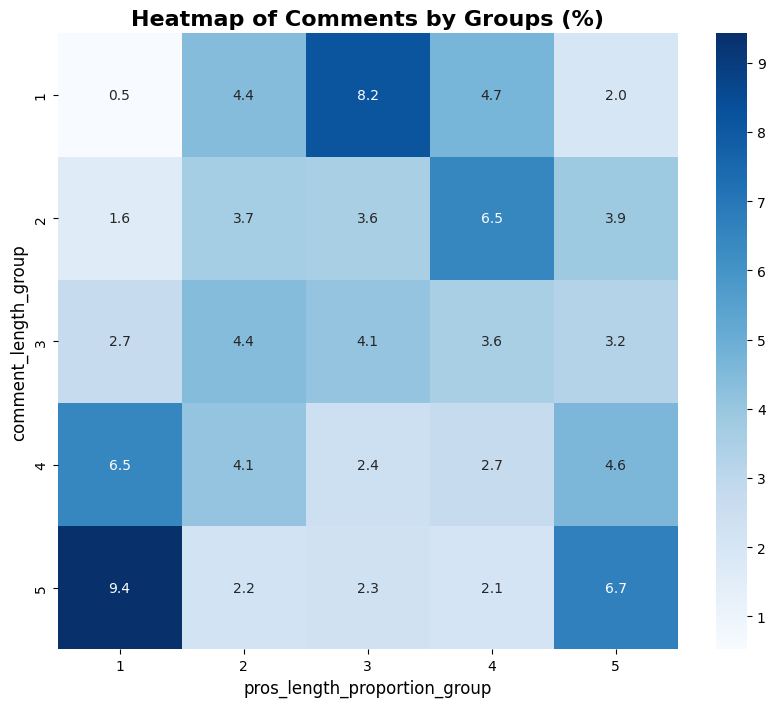

In [13]:
cross_tab = pd.crosstab(df['comment_length_group'], df['pros_length_proportion_group'])

# Calcula o total de comentários e converte as contagens em porcentagens
total_comments = cross_tab.values.sum()
cross_tab_percent = (cross_tab / total_comments) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap of Comments by Groups (%)", fontsize=16, fontweight="bold")
plt.xlabel("pros_length_proportion_group", fontsize=12)
plt.ylabel("comment_length_group", fontsize=12)
plt.show()

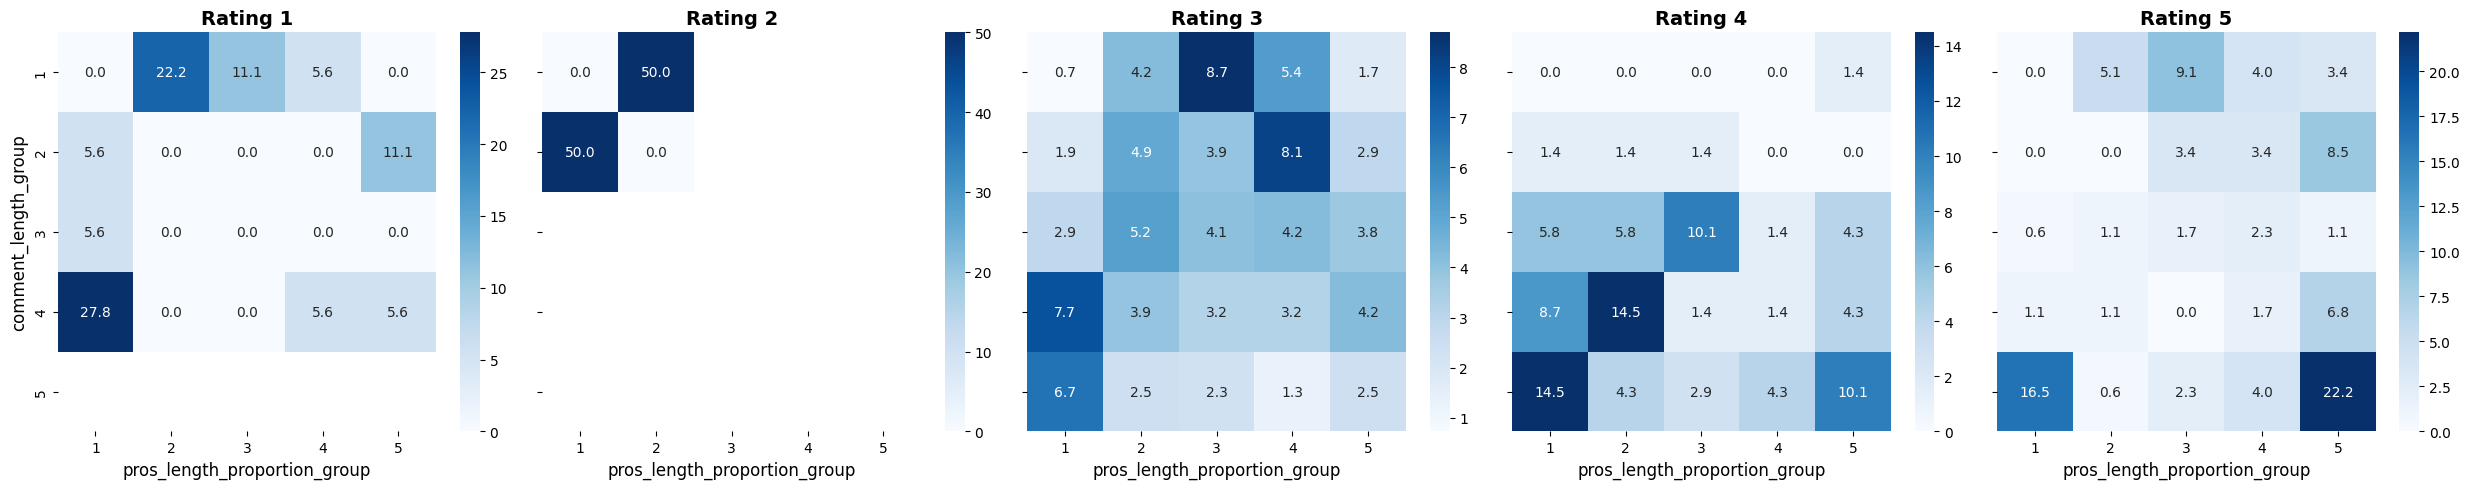

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

for rating in range(1, 6):
    # Filtra o DataFrame para o rating atual
    df_filtered = df[df['rating'] == rating]
    
    # Cria uma tabela cruzada com as contagens
    cross_tab = pd.crosstab(df_filtered['comment_length_group'], df_filtered['pros_length_proportion_group'])
    
    # Calcula o total de comentários para o rating filtrado
    total_comments = cross_tab.values.sum()
    
    # Converte as contagens em porcentagens (se houver comentários)
    if total_comments > 0:
        cross_tab_percent = (cross_tab / total_comments) * 100
    else:
        cross_tab_percent = cross_tab.copy()
    
    # Gera o heatmap no subplot correspondente
    sns.heatmap(cross_tab_percent, annot=True, fmt=".1f", cmap="Blues", ax=axes[rating-1])
    axes[rating-1].set_title(f'Rating {rating}', fontsize=14, fontweight='bold')
    axes[rating-1].set_xlabel("pros_length_proportion_group", fontsize=12)
    if rating == 1:
        axes[rating-1].set_ylabel("comment_length_group", fontsize=12)
    else:
        axes[rating-1].set_ylabel("")

plt.tight_layout()

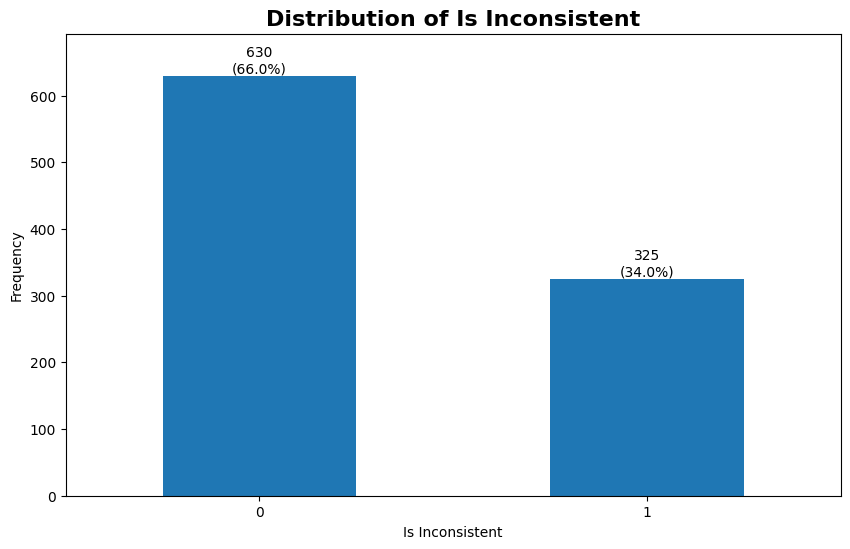

In [15]:
rating_counts = df['is_inconsistent'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Is Inconsistent')
plt.ylabel('Frequency')
plt.title('Distribution of Is Inconsistent', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()